### Import library

In [ ]:
# module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, make_scorer

###Load data

In [ ]:
# fetch the training file
file_path_training_set = '/content/KDDTrain+.txt'
file_path_testing_set = '/content/KDDTest+.txt'

df = pd.read_csv(file_path_training_set)
test_df = pd.read_csv(file_path_testing_set)

In [ ]:
#data set doesn't include column names, add them.
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment',
            'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
            'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
            'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
            'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
            'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
            'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',
            'attack','level'])

df.columns = columns
test_df.columns = columns

# sanity check
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [ ]:
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
U2R = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
Sybil = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','U2R','Sybil']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in U2R:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in Sybil:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0

    return attack_type

# map the data and join to the data set
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


### Preproccessing data

In [ ]:
# helper function for drawing mulitple charts.
def bake_pies(data_list,labels):
    list_length = len(data_list)

    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}

    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)

    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list):

        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)

        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Classes",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])

    return axs

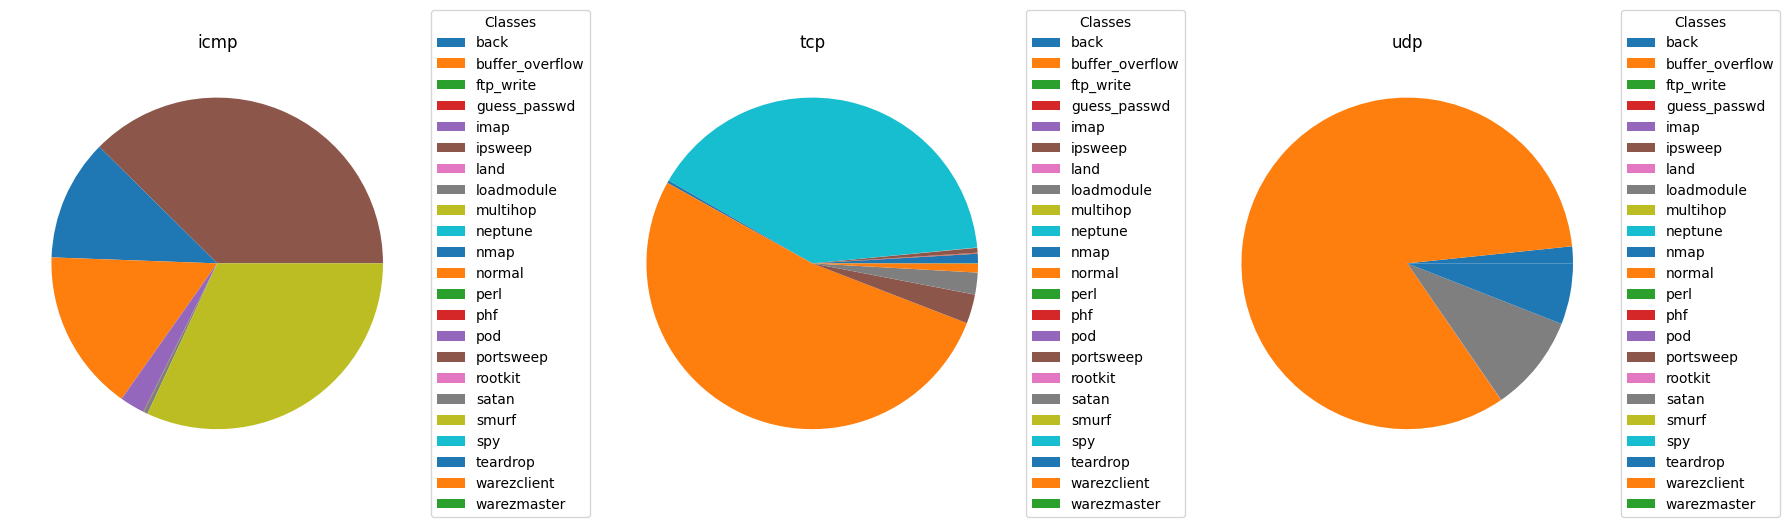

In [ ]:
# attack vs MCS protocols
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)

# get the series for each protocol
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

In [ ]:
# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

# not all of the features are in the test set, so we need to account for diffs
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

# we'll also need to reorder the columns to match, so let's get those
column_order = encoded.columns.to_list()

# append the new columns
test_encoded_temp = test_encoded_base.join(diff_df)

# reorder the columns
test_final = test_encoded_temp[column_order].fillna(0)

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'src_bytes', 'dst_bytes']

# model to fit/test
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

In [ ]:
to_fit.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,0,146,0
1,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,0,0,0
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,0,232,8153
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,0,199,420
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0


In [ ]:
# create our target classifications
train_X = to_fit
train_y = df['attack_map']

test_X = test_set
test_y = test_df['attack_map']

print(train_y.shape)
print(test_y.shape)

print(test_y.unique())

(125972,)
(22543,)
[1 0 2 4 3]


### Create and train model

In [ ]:
# model for the binary classification
model = RandomForestClassifier()
model.fit(train_X, train_y)
predictions = model.predict(test_X)

# calculate and display our base accuracty
base_rf_score = accuracy_score(predictions, test_y)
base_rf_score

0.7526948498425232

### Test on other models

In [ ]:
# define the list of models that we want to test
models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    LogisticRegression(max_iter=500),
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(),
    StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                                    ('gb', GradientBoostingClassifier()),
                                    ('xgb', XGBClassifier())],
                       final_estimator=LogisticRegression(), cv=5)
]

# an empty list to capture the performance of each model
model_comps = []

# walk through the models and populate our list
for model in models:
    model_name = model.__class__.__name__
    print(f'Training {model_name}')

    model.fit(train_X, train_y)
    predictions = model.predict(test_X)
    acc = accuracy_score(predictions, test_y)
    f1 = f1_score(predictions, test_y, average='macro')

    print(f'Accuracy: {acc}, F1 Score: {f1}')

    model_comps.append((model_name, acc, f1))

Training RandomForestClassifier
Accuracy: 0.7529166481834716, F1 Score: 0.5716790690817405
Training GradientBoostingClassifier
Accuracy: 0.7720800248414141, F1 Score: 0.5158695960473831
Training XGBClassifier
Accuracy: 0.77265670052788, F1 Score: 0.6212737984335513
Training LogisticRegression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.5812890919575922, F1 Score: 0.2677624363222014
Training KNeighborsClassifier
Accuracy: 0.7499889100829525, F1 Score: 0.533017699615149
Training GaussianNB
Accuracy: 0.285498824468793, F1 Score: 0.10491215100175391
Training SVC
Accuracy: 0.4370314510047465, F1 Score: 0.12164840253125482
Training StackingClassifier
Accuracy: 0.7500332697511423, F1 Score: 0.5459634013206877


In [ ]:
print(model_comps)

[('RandomForestClassifier', 0.7529166481834716, 0.5716790690817405), ('GradientBoostingClassifier', 0.7720800248414141, 0.5158695960473831), ('XGBClassifier', 0.77265670052788, 0.6212737984335513), ('LogisticRegression', 0.5812890919575922, 0.2677624363222014), ('KNeighborsClassifier', 0.7499889100829525, 0.533017699615149), ('GaussianNB', 0.285498824468793, 0.10491215100175391), ('SVC', 0.4370314510047465, 0.12164840253125482), ('StackingClassifier', 0.7500332697511423, 0.5459634013206877)]


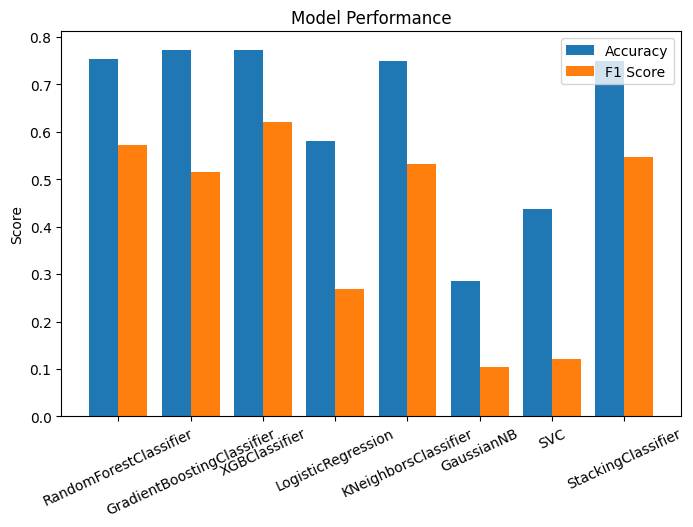

In [ ]:
X = [result[0] for result in model_comps]
X_axis = np.arange(len(X))

plt.figure(figsize=(8, 5))

plt.bar(X_axis - 0.2, [result[1] for result in model_comps], 0.4, label='Accuracy')
plt.bar(X_axis + 0.2, [result[2] for result in model_comps], 0.4, label='F1 Score')

plt.xticks(X_axis, X, rotation=25)
plt.ylabel('Score')
plt.title('Model Performance')
plt.legend()
plt.show()